# Pre Processing

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
from PIL import Image
import shutil

# Define the paths
data_dir = "/kaggle/input/indonesian-batik-motifs"
desired_classes = ['batik-bali', 'batik-betawi', 'batik-keraton']

2024-06-21 19:51:03.728840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 19:51:03.728926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 19:51:03.847201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Ensure only desired classes are included
filtered_data_dir = os.path.join(data_dir, '/kaggle/working/filtered')
os.makedirs(filtered_data_dir, exist_ok=True)
for class_name in desired_classes:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.exists(class_dir):
        dest_dir = os.path.join(filtered_data_dir, class_name)
        if not os.path.exists(dest_dir):
            os.symlink(class_dir, dest_dir)  # create a symbolic link to the class directory


In [3]:
# Create directories for train, val, test splits
segmented_directory = os.path.join(filtered_data_dir, '/kaggle/working/segmented_batik')
for folder in ['train', 'val', 'test']:
    for class_name in desired_classes:
        os.makedirs(os.path.join(segmented_directory, folder, class_name), exist_ok=True)

# Split the data into train, validation, and test sets
train_size = 0.7
val_size = 0.1  # validation size
test_size = 0.2  # test size
for batik in desired_classes:
    folder_path = os.path.join(filtered_data_dir, batik)
    all_files = os.listdir(folder_path)
    
    length_train = round(len(all_files) * train_size)
    length_val = round(len(all_files) * val_size)
    
    train_files = all_files[:length_train]
    val_files = all_files[length_train:length_train + length_val]
    test_files = all_files[length_train + length_val:]
    
    splited_data = [("train", train_files), ("val", val_files), ("test", test_files)]
    
    for data_type, file_list in splited_data:
        target_dir = os.path.join(segmented_directory, data_type, batik)
        os.makedirs(target_dir, exist_ok=True)
        
        for filename in file_list:
            source_path = os.path.join(folder_path, filename)
            target_path = os.path.join(target_dir, filename)
            shutil.copy2(source_path, target_path)

# Load the data from the segmented directory
batch_size = 2048
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(segmented_directory, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(segmented_directory, 'val'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(segmented_directory, 'test'),
    image_size=(img_height, img_width),
    batch_size=32
)

train_data = train_ds.concatenate(test_ds)
train_data = train_data.concatenate(val_ds)
train_data = train_data.map(lambda x, y: x)

Found 105 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 30 files belonging to 3 classes.


In [4]:
# Convert the dataset to numpy array
train_data_np = np.concatenate(list(train_data.as_numpy_iterator()))

train_data_mean = np.mean(train_data_np)
train_data_std = np.std(train_data_np)

# Normalize the pixel values
def normalize(image, label):
    return (image - train_data_mean) / train_data_std, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize the dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# From Scratch


In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU

num_classes = len(desired_classes)  
input_shape = (img_height, img_width, 3)

model = Sequential([
    Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001), input_shape=input_shape),
    BatchNormalization(), 
    LeakyReLU(alpha=0.1),
    Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)), 
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(), 
    LeakyReLU(alpha=0.1),
    Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 56, 56, 128)    │             

 Total params: 51,673,123 (197.12 MB)

 Trainable params: 51,671,203 (197.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

print("Evaluasi model pada data uji:")
loss, accuracy = model.evaluate(test_ds)
print("Akurasi: {:.2f}%".format(accuracy * 100))


Epoch 1/100


2024-06-21 17:26:53.955746: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[105,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[105,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-21 17:26:54.118641: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.7616, expected 4.09951
2024-06-21 17:26:54.118693: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.27579, expected 4.61371
2024-06-21 17:26:54.118702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.38094, expected 4.71886
2024-06-21 17:26:54.118710: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - accuracy: 0.3714 - loss: 1.6771

2024-06-21 17:27:36.225862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.53173, expected 3.64863
2024-06-21 17:27:36.225945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.90679, expected 5.02369
2024-06-21 17:27:36.225963: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 7.34085, expected 6.45775
2024-06-21 17:27:36.225981: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.00665, expected 5.12355
2024-06-21 17:27:36.225993: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.66198, expected 4.77889
2024-06-21 17:27:36.226004: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 7.31979, expected 6.43669
2024-06-21 17:27:36.226014: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.88499, expected 5.00189
2024-06-21 17:27:36.226024:

1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 0.3714 - loss: 1.6771 - val_accuracy: 0.3333 - val_loss: 1.4801 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.4095 - loss: 4.6910 - val_accuracy: 0.3333 - val_loss: 1.3900 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.3810 - loss: 3.1639 - val_accuracy: 0.3333 - val_loss: 1.2353 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4571 - loss: 2.0308 - val_accuracy: 0.5333 - val_loss: 1.1630 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3714 - loss: 1.5891 - val_accuracy: 0.4667 - val_loss: 1.1786 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4095 - loss: 1.3945 - val_accuracy: 0.3333 - val_loss: 1.2346 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4095 - loss: 1.337

2024-06-21 17:27:42.918424: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.61233, expected 3.04092
2024-06-21 17:27:42.918482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.46627, expected 3.89485
2024-06-21 17:27:42.918491: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.41222, expected 3.84081
2024-06-21 17:27:42.918500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.02418, expected 2.45277
2024-06-21 17:27:42.918507: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.88651, expected 3.31509
2024-06-21 17:27:42.918515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 4.18259, expected 3.61118
2024-06-21 17:27:42.918523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.50085, expected 2.92944
2024-06-21 17:27:42.918530: E external/local_xla/x

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4333 - loss: 1.2155
Akurasi: 43.33%


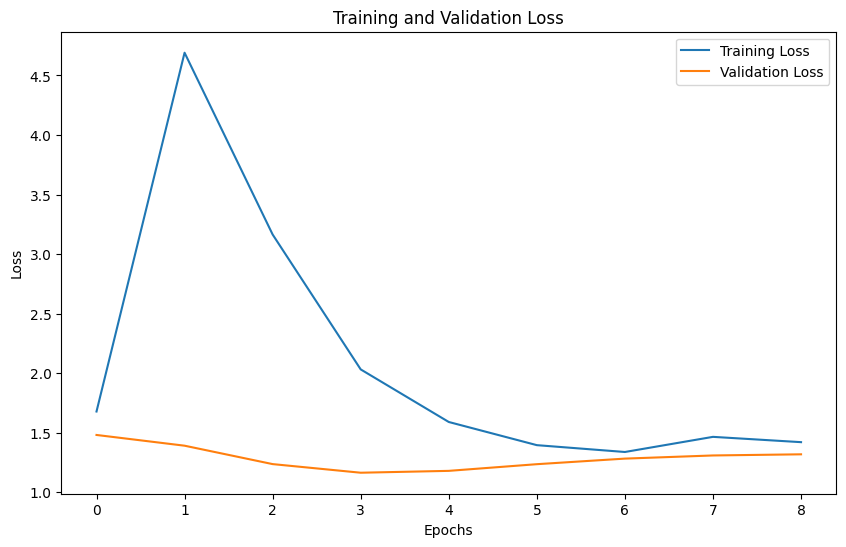

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the function to plot the loss
plot_loss(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


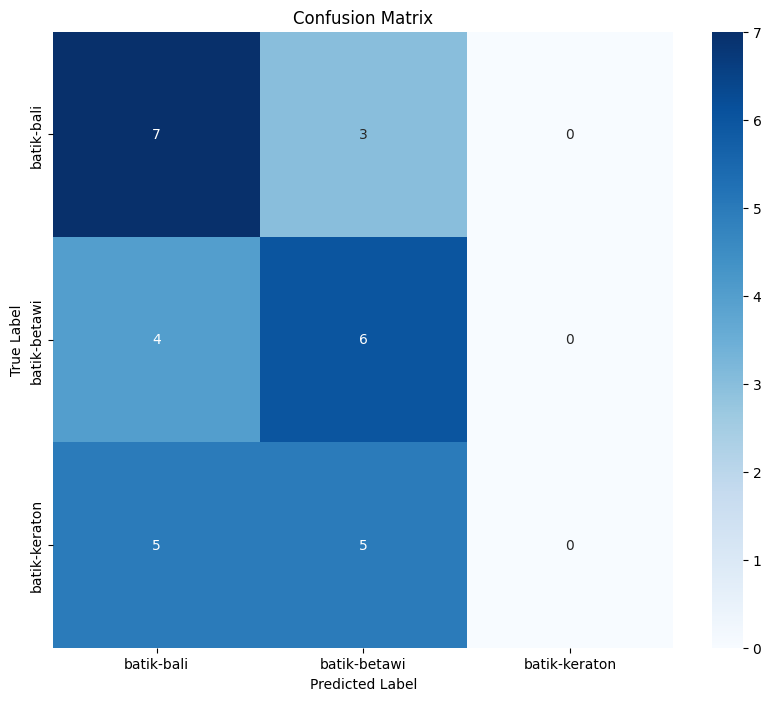

In [9]:
# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=desired_classes)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
               precision    recall  f1-score   support

   batik-bali       0.44      0.70      0.54        10
 batik-betawi       0.43      0.60      0.50        10
batik-keraton       0.00      0.00      0.00        10

     accuracy                           0.43        30
    macro avg       0.29      0.43      0.35        30
 weighted avg       0.29      0.43      0.35        30



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

num_classes = len(desired_classes)  
input_shape = (img_height, img_width, 3)

model = Sequential([
    Conv2D(16, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001), input_shape=input_shape),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.1),

    Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.1),

    Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.1),

    Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),
    Dropout(0.1),

    GlobalAveragePooling2D(),

    Dense(1024, kernel_regularizer=regularizers.l2(0.0001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-6)

# Make sure to use the correct datasets
epochs = 100
history = model.fit(
    train_ds,  # Changed to use training data
    validation_data=val_ds,  # Changed to use validation data
    epochs=epochs,
    callbacks=[reduce_lr]  # Added early stopping callback
)

print("Evaluasi model pada data uji:")
loss, accuracy = model.evaluate(test_ds)
print("Akurasi: {:.2f}%".format(accuracy * 100))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,611 (908.64 KB)

 Trainable params: 232,611 (908.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3714 - loss: 1.1303

2024-06-21 17:34:04.607063: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.58618, expected 3.64863
2024-06-21 17:34:04.607121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.96124, expected 5.02369
2024-06-21 17:34:04.607130: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 7.39531, expected 6.45775
2024-06-21 17:34:04.607138: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.0611, expected 5.12355
2024-06-21 17:34:04.607146: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.71644, expected 4.77889
2024-06-21 17:34:04.607153: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 7.37424, expected 6.43669
2024-06-21 17:34:04.607161: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.93944, expected 5.00189
2024-06-21 17:34:04.607169: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.3714 - loss: 1.1303 - val_accuracy: 0.4000 - val_loss: 1.1340 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3524 - loss: 1.1541 - val_accuracy: 0.2667 - val_loss: 1.1334 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3714 - loss: 1.1301 - val_accuracy: 0.3333 - val_loss: 1.1340 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3429 - loss: 1.1415 - val_accuracy: 0.3333 - val_loss: 1.1347 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3333 - loss: 1.1465 - val_accuracy: 0.3333 - val_loss: 1.1343 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3048 - loss: 1.1596 - val_accuracy: 0.3333 - val_loss: 1.1339 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3524 - loss: 1.1718 - va

2024-06-21 17:34:13.707464: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.01676, expected 3.04092
2024-06-21 17:34:13.707521: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.52565, expected 5.54981
2024-06-21 17:34:13.707531: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.49189, expected 5.51604
2024-06-21 17:34:13.707540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.53901, expected 4.56316
2024-06-21 17:34:13.707548: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.87568, expected 4.89984
2024-06-21 17:34:13.707556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.95943, expected 4.98359
2024-06-21 17:34:13.707564: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.4166, expected 4.44075
2024-06-21 17:34:13.707572: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 1.1377
Akurasi: 40.00%


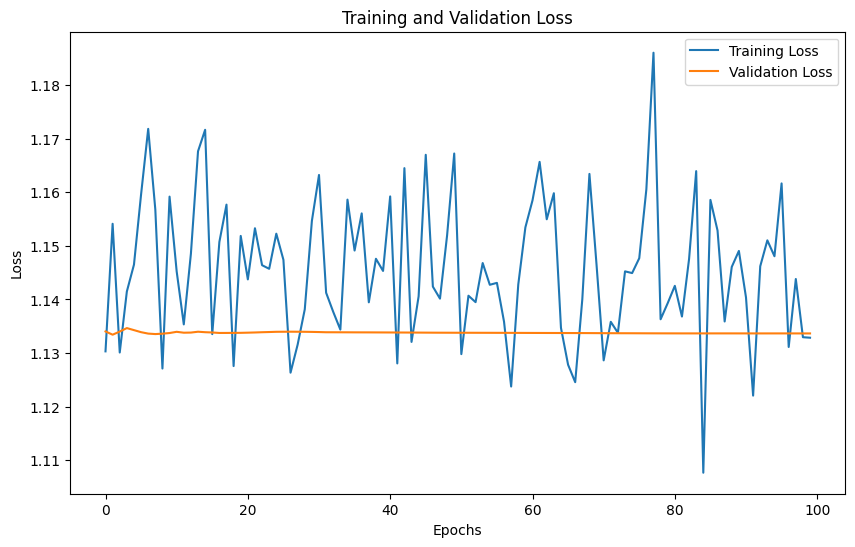

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the function to plot the loss
plot_loss(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


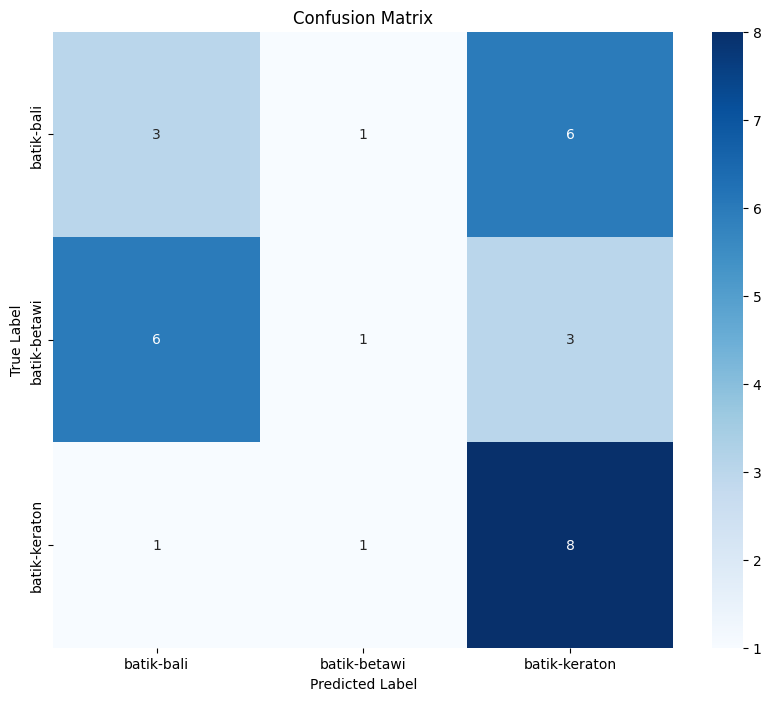

In [15]:
# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=desired_classes)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
               precision    recall  f1-score   support

   batik-bali       0.30      0.30      0.30        10
 batik-betawi       0.33      0.10      0.15        10
batik-keraton       0.47      0.80      0.59        10

     accuracy                           0.40        30
    macro avg       0.37      0.40      0.35        30
 weighted avg       0.37      0.40      0.35        30



# DIY

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np


# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the model architecture
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(desired_classes), activation='softmax')
])
model.build((None, img_height, img_width, 3))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Custom callback to save the best model based on val_loss, val_accuracy, and accuracy training
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', monitor2='val_accuracy', monitor3='accuracy', mode='min', mode2='max', mode3='max', save_best_only=True):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.monitor2 = monitor2
        self.monitor3 = monitor3
        self.mode = mode
        self.mode2 = mode2
        self.mode3 = mode3
        self.save_best_only = save_best_only
        self.best = np.Inf if mode == 'min' else -np.Inf
        self.best2 = -np.Inf if mode2 == 'max' else np.Inf
        self.best3 = -np.Inf if mode3 == 'max' else np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        current2 = logs.get(self.monitor2)
        current3 = logs.get(self.monitor3)
        
        if self.save_best_only:
            if self.mode == 'min' and self.mode2 == 'max' and self.mode3 == 'max':
                if current < self.best and current2 > self.best2 and current3 > self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'max' and self.mode2 == 'min' and self.mode3 == 'max':
                if current > self.best and current2 < self.best2 and current3 > self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'min' and self.mode2 == 'max' and self.mode3 == 'min':
                if current < self.best and current2 > self.best2 and current3 < self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'max' and self.mode2 == 'min' and self.mode3 == 'min':
                if current > self.best and current2 < self.best2 and current3 < self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
        else:
            self.model.save(self.filepath, overwrite=True)

# Define the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint('best_model_custom.h5', 
                                          monitor='val_loss', monitor2='val_accuracy', monitor3='accuracy', 
                                          mode='min', mode2='max', mode3='max', 
                                          save_best_only=True)

# Train the model with the custom checkpoint callback
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[reduce_lr, custom_checkpoint])

# Load the best model for fine-tuning
model = tf.keras.models.load_model('best_model_custom.h5')

# Unfreeze the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:len(base_model.layers) // 2]:
    layer.trainable = False

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=500,  # Adjust the number of epochs for fine-tuning
                         callbacks=[reduce_lr])

# Evaluate the fine-tuned model on the test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/working/segmented_batik/test',
    image_size=(img_height, img_width),
    batch_size=32)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy after fine-tuning: {test_acc}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3238 - loss: 2.1503

I0000 00:00:1718999567.308762     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718999567.346268     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.3238 - loss: 2.1503 - val_accuracy: 0.2000 - val_loss: 2.2529 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3905 - loss: 1.9450 - val_accuracy: 0.1333 - val_loss: 2.2265 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4000 - loss: 1.9804 - val_accuracy: 0.1333 - val_loss: 2.2120 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3714 - loss: 1.9946 - val_accuracy: 0.1333 - val_loss: 2.2008 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4000 - loss: 1.9694 - val_accuracy: 0.2000 - val_loss: 2.1984 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4000 - loss: 1.8577 - val_accuracy: 0.3333 - val_loss: 2.2018 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4000 - loss: 1.8936 - v

W0000 00:00:1718999590.905656     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4857 - loss: 1.8587 - val_accuracy: 0.4000 - val_loss: 2.1948 - learning_rate: 1.0000e-05
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4571 - loss: 1.8366 - val_accuracy: 0.4000 - val_loss: 2.1902 - learning_rate: 1.0000e-05
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5048 - loss: 1.7726 - val_accuracy: 0.4000 - val_loss: 2.1862 - learning_rate: 1.0000e-05
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3619 - loss: 1.8583 - val_accuracy: 0.4000 - val_loss: 2.1828 - learning_rate: 1.0000e-05
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4000 - loss: 1.8646 - val_accuracy: 0.4000 - val_loss: 2.1795 - learning_rate: 1.0000e-05
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5333 - loss: 1.7598 - val_accuracy: 0.4000 - val_loss: 2.1770 - learning_rate: 1.0000e-05
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3905 - loss: 1.9054 - va

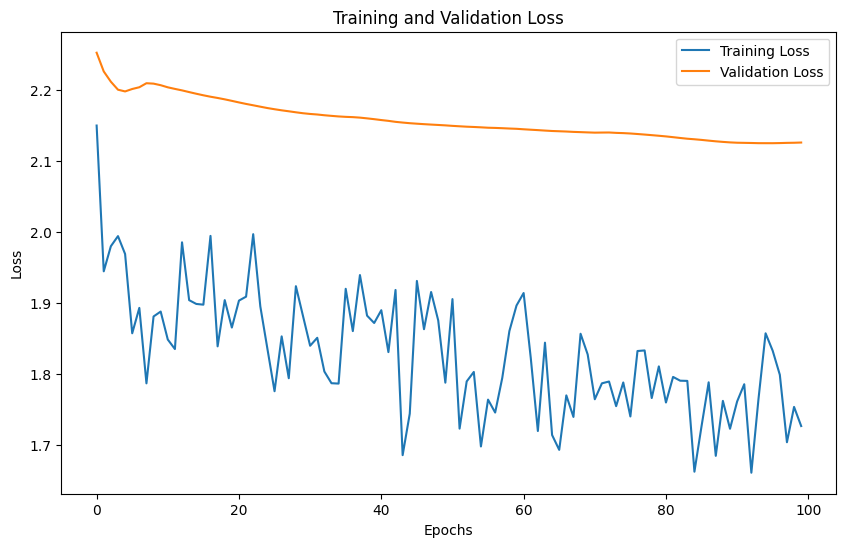

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the function to plot the loss
plot_loss(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


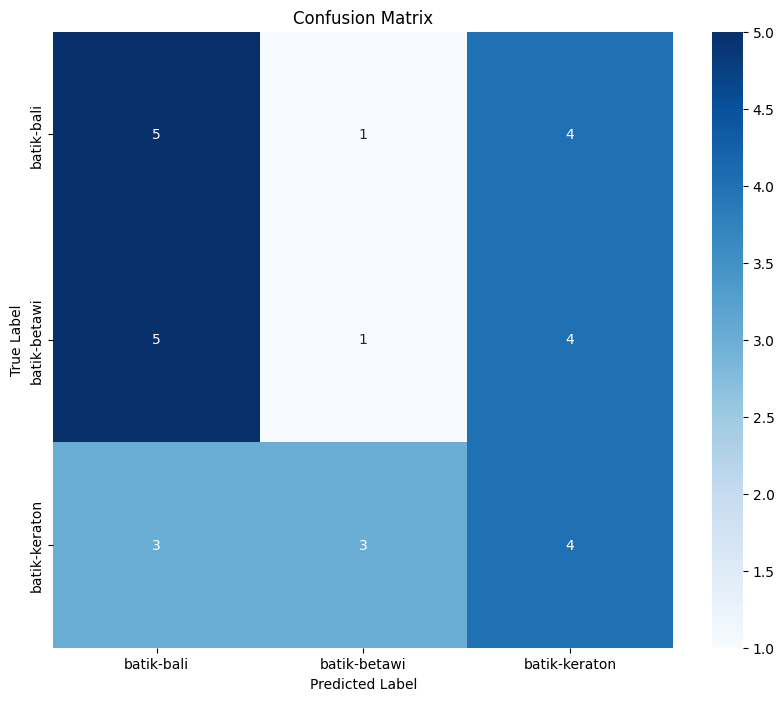

In [7]:
import seaborn as sns
# Predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Kita sudah coba ini sebelumnya cuman tidak di run lagi, karena jumlah epoch yang sangat banyak, kemarinnya mendapatkan 0.69 accuracy setelah fine tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np


# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the model architecture
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(desired_classes), activation='softmax')
])
model.build((None, img_height, img_width, 3))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Custom callback to save the best model based on val_loss, val_accuracy, and accuracy training
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', monitor2='val_accuracy', monitor3='accuracy', mode='min', mode2='max', mode3='max', save_best_only=True):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.monitor2 = monitor2
        self.monitor3 = monitor3
        self.mode = mode
        self.mode2 = mode2
        self.mode3 = mode3
        self.save_best_only = save_best_only
        self.best = np.Inf if mode == 'min' else -np.Inf
        self.best2 = -np.Inf if mode2 == 'max' else np.Inf
        self.best3 = -np.Inf if mode3 == 'max' else np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        current2 = logs.get(self.monitor2)
        current3 = logs.get(self.monitor3)
        
        if self.save_best_only:
            if self.mode == 'min' and self.mode2 == 'max' and self.mode3 == 'max':
                if current < self.best and current2 > self.best2 and current3 > self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'max' and self.mode2 == 'min' and self.mode3 == 'max':
                if current > self.best and current2 < self.best2 and current3 > self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'min' and self.mode2 == 'max' and self.mode3 == 'min':
                if current < self.best and current2 > self.best2 and current3 < self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
            elif self.mode == 'max' and self.mode2 == 'min' and self.mode3 == 'min':
                if current > self.best and current2 < self.best2 and current3 < self.best3:
                    self.best = current
                    self.best2 = current2
                    self.best3 = current3
                    self.model.save(self.filepath, overwrite=True)
        else:
            self.model.save(self.filepath, overwrite=True)

# Define the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint('best_model_custom.h5', 
                                          monitor='val_loss', monitor2='val_accuracy', monitor3='accuracy', 
                                          mode='min', mode2='max', mode3='max', 
                                          save_best_only=True)

# Train the model with the custom checkpoint callback
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[reduce_lr, custom_checkpoint])

# Load the best model for fine-tuning
model = tf.keras.models.load_model('best_model_custom.h5')

# Unfreeze the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:len(base_model.layers) // 2]:
    layer.trainable = False

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=500,  # Adjust the number of epochs for fine-tuning
                         callbacks=[reduce_lr])

# Evaluate the fine-tuned model on the test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/working/segmented_batik/test',
    image_size=(img_height, img_width),
    batch_size=32)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy after fine-tuning: {test_acc}")

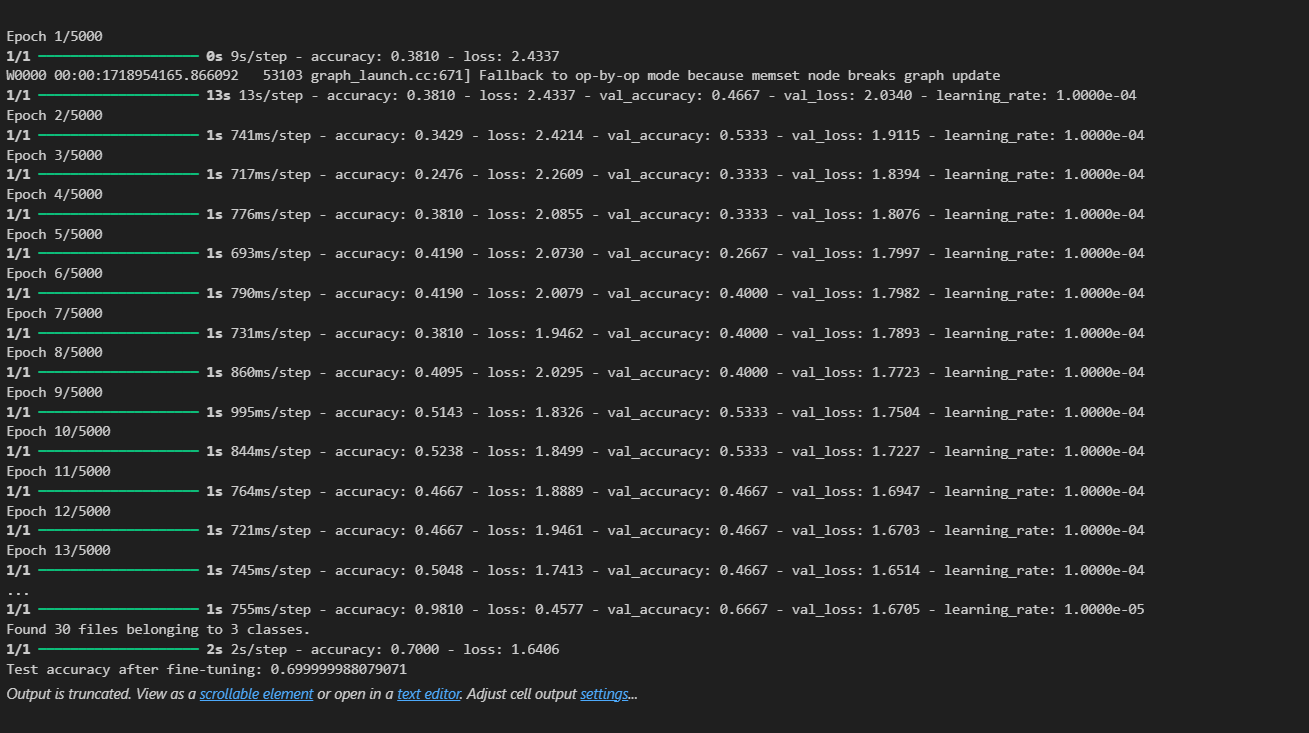